Import Libraries

In [2]:
# import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline
print('Packages installed  :)')

Packages installed  :)


In [3]:
!pip install folium==0.5. # map rendering library

     |████████████████████████████████| 79 kB 7.6 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=b56cddd5da3386a3ba3a6fa53093c50a5d81862576e6ebaffa073b169ffa58f3
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium


In [49]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [50]:
import requests
import csv

In [4]:
# Get the neighborhood data using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

In [5]:
# Now we will read the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))
neigh = soup.find('table')
table_str = str(neigh.extract())

In [6]:
df = pd.read_html(table_str)[0]
df.head()

Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

We will remove the Not assigned Boroughs

In [7]:
df_dropna = df[df.Borough != 'Not assigned'].reset_index(drop=True)

We will rename Postal Code to PostalCode,looks prettier!

In [8]:
df_dropna.rename(columns={'Postal Code' : 'PostalCode'}, inplace=True)

In [9]:
df = df_dropna

In [10]:
df.head ()

PostalCode           Borough                                Neighbourhood
0        M3A        North York                                    Parkwoods
1        M4A        North York                             Victoria Village
2        M5A  Downtown Toronto                    Regent Park, Harbourfront
3        M6A        North York             Lawrence Manor, Lawrence Heights
4        M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

GROUPING: WE WILL GROUP THE DATABASE BASED ON BOROUGH. WE WILL ALSO PUT POSTAL CODE ON THE LEFT

In [11]:
df_grouped = df.groupby(['PostalCode','Borough'], as_index=False).agg(lambda x:','.join(x))
df_grouped.head()

PostalCode      Borough                           Neighbourhood
0        M1B  Scarborough                          Malvern, Rouge
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek
2        M1E  Scarborough       Guildwood, Morningside, West Hill
3        M1G  Scarborough                                  Woburn
4        M1H  Scarborough                               Cedarbrae

In [12]:
# CHECKING TO SEE IF WE HAVE ANY NEIGHBOURHOODS THAT ARE NOT ASSIGNED
df_grouped.loc[df_grouped['Borough'].isin(["Not assigned"])]

Empty DataFrame
Columns: [PostalCode, Borough, Neighbourhood]
Index: []

DATA CLEANSED: ALL REQUIREMENTS MET, TIME TO ADD LATITUDE AND LONGITUDE TO THE DATAFRAME

In [13]:
df = df_grouped

In [27]:
df.head ()

PostalCode      Borough                           Neighbourhood
0        M1B  Scarborough                          Malvern, Rouge
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek
2        M1E  Scarborough       Guildwood, Morningside, West Hill
3        M1G  Scarborough                                  Woburn
4        M1H  Scarborough                               Cedarbrae

CREATE A NEW TABLE WITH CORRESPONDING LATITUDE AND LONGITUDE FOR EACH POSTAL CODE

In [14]:
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

MERGING: We Will merge the actual data to equal to the temporary data frame  based on postal code.

In [15]:
# Merging the Data
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

PostalCode      Borough                           Neighbourhood   Latitude  \
0        M1B  Scarborough                          Malvern, Rouge  43.806686   
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [16]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighbourhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighbourhood, dtype: int64

LET US FIND ALL THE DATA THAT HAS TORONTO IN IT.

In [17]:
df_toronto = df
df_toronto.head()

PostalCode      Borough                           Neighbourhood   Latitude  \
0        M1B  Scarborough                          Malvern, Rouge  43.806686   
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [18]:
#Create list with the Boroughs (to be used later)
boroughs = df_toronto['Borough'].unique().tolist()

In [19]:
#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165048


In [20]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [21]:
import folium
latitude= 43.70460773398059
longitude = -79.39715291165048

In [22]:
# create map of Toronto using latitude and longitude values
map_toronto =folium.Map(location=[latitude, longitude], zoom_start=10.5)

In [35]:
map_toronto = folium.Map (location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighbourhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

In [43]:
CLIENT_ID = 'CAZHESWWOTWXRE4UD22K4EAPKSKMKKEBOV0CGQAGQ5CWPOYC' # your Foursquare ID
CLIENT_SECRET = 'T3DRMTZ4ADXFC1UFKLRFT0QXN2MGTHMOE34AEAZK1ZETRB01' # your Foursquare Secret
ACCESS_TOKEN = '"D4OIZMIQ4IYS3DKNR1DF4YMOFWDUDM51EWN31PJHK0WZUC3V"' # your FourSquare Access Token
VERSION = '20180604' 
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('Credentials Stored')

Your credentails:
CLIENT_ID: CAZHESWWOTWXRE4UD22K4EAPKSKMKKEBOV0CGQAGQ5CWPOYC
CLIENT_SECRET:T3DRMTZ4ADXFC1UFKLRFT0QXN2MGTHMOE34AEAZK1ZETRB01
Credentials Stored


In [44]:
ACCESS_TOKEN = 'D4OIZMIQ4IYS3DKNR1DF4YMOFWDUDM51EWN31PJHK0WZUC3V'
print (ACCESS_TOKEN)

D4OIZMIQ4IYS3DKNR1DF4YMOFWDUDM51EWN31PJHK0WZUC3V


In [45]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [46]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [47]:
toronto_venues.head()

Neighbourhood  Neighbourhood Latitude  \
0                          Malvern, Rouge               43.806686   
1  Rouge Hill, Port Union, Highland Creek               43.784535   
2  Rouge Hill, Port Union, Highland Creek               43.784535   
3       Guildwood, Morningside, West Hill               43.763573   
4       Guildwood, Morningside, West Hill               43.763573   

   Neighbourhood Longitude                           Venue  Venue Latitude  \
0               -79.194353                         Wendy’s       43.807448   
1               -79.160497           Royal Canadian Legion       43.782533   
2               -79.160497  Scarborough Historical Society       43.788755   
3               -79.188711                  RBC Royal Bank       43.766790   
4               -79.188711               G & G Electronics       43.765309   

   Venue Longitude        Venue Category  
0       -79.199056  Fast Food Restaurant  
1       -79.163085                   Bar  
2       -79.162438        History Museum  
3       -79.191151                  Bank  
4       -79.191537     Electronics Store

Lets check how many venues per neighborhood

In [48]:
toronto_venues.groupby('Neighbourhood').count()

Neighbourhood Latitude  \
Neighbourhood                                                             
Agincourt                                                             4   
Alderwood, Long Branch                                                8   
Bathurst Manor, Wilson Heights, Downsview North                      23   
Bayview Village                                                       4   
Bedford Park, Lawrence Manor East                                    24   
...                                                                 ...   
Willowdale, Willowdale West                                           5   
Woburn                                                                4   
Woodbine Heights                                                      6   
York Mills West                                                       2   
York Mills, Silver Hills                                              1   

                                                 Neighbourhood Longitude  \
Neighbourhood                                                              
Agincourt                                                              4   
Alderwood, Long Branch                                                 8   
Bathurst Manor, Wilson Heights, Downsview North                       23   
Bayview Village                                                        4   
Bedford Park, Lawrence Manor East                                     24   
...                                                                  ...   
Willowdale, Willowdale West                                            5   
Woburn                                                                 4   
Woodbine Heights                                                       6   
York Mills West                                                        2   
York Mills, Silver Hills                                               1   

                                                 Venue  Venue Latitude  \
Neighbourhood                                                            
Agincourt                                            4               4   
Alderwood, Long Branch                               8               8   
Bathurst Manor, Wilson Heights, Downsview North     23              23   
Bayview Village                                      4               4   
Bedford Park, Lawrence Manor East                   24              24   
...                                                ...             ...   
Willowdale, Willowdale West                          5               5   
Woburn                                               4               4   
Woodbine Heights                                     6               6   
York Mills West                                      2               2   
York Mills, Silver Hills                             1               1   

                                                 Venue Longitude  \
Neighbourhood                                                      
Agincourt                                                      4   
Alderwood, Long Branch                                         8   
Bathurst Manor, Wilson Heights, Downsview North               23   
Bayview Village                                                4   
Bedford Park, Lawrence Manor East                             24   
...                                                          ...   
Willowdale, Willowdale West                                    5   
Woburn                                                         4   
Woodbine Heights                                               6   
York Mills West                                                2   
York Mills, Silver Hills                                       1   

                                                 Venue Category  
Neighbourhood                                                    
Agincourt                                                     4  
Alderwood, Long Branch                

We need to find out how many unique values are there.

In [51]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 267 uniques categories.


In [52]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Fast Food Restaurant' 'Bar' 'History Museum' 'Bank' 'Electronics Store'
 'Restaurant' 'Mexican Restaurant' 'Rental Car Location' 'Medical Center'
 'Intersection' 'Breakfast Spot' 'Coffee Shop' 'Korean BBQ Restaurant'
 'Indian Restaurant' 'Hakka Restaurant' 'Caribbean Restaurant'
 'Thai Restaurant' 'Athletics & Sports' 'Bakery' 'Gas Station'
 'Fried Chicken Joint' 'Playground' 'Business Service' 'Department Store'
 'Convenience Store' 'Chinese Restaurant' 'Hobby Shop' 'Discount Store'
 'Ice Cream Shop' 'Bus Line' 'Bus Station' 'Park' 'Soccer Field' 'Motel'
 'American Restaurant' 'Café' 'General Entertainment' 'Farm'
 'Skating Rink' 'College Stadium' 'Pet Store' 'Vietnamese Restaurant'
 'Light Rail Station' 'Sandwich Place' 'Middle Eastern Restaurant'
 'Shopping Mall' 'Smoke Shop' 'Auto Garage' 'Latin American Restaurant'
 'Lounge' 'Italian Restaurant' 'Noodle House' 'Pizza Place' 'Pharmacy'
 'Gym' 'Supermarket' 'Golf Course' 'Pool' 'Mediterranean Restaurant'
 

Are there any Caribbean Restaurants in the venues?

In [116]:
"Caribbean Restaurant" in toronto_venues['Venue Category'].unique()

True

Now we will analyze each neighborhood

In [117]:
 #one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
to_onehot['Neighbourhoods'] = toronto_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2122, 268)


Neighbourhoods  Accessories Store  Adult Boutique  \
0                          Malvern, Rouge                  0               0   
1  Rouge Hill, Port Union, Highland Creek                  0               0   
2  Rouge Hill, Port Union, Highland Creek                  0               0   
3       Guildwood, Morningside, West Hill                  0               0   
4       Guildwood, Morningside, West Hill                  0               0   

   Airport  Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0        0                   0             0               0                0   
1        0                   0             0               0                0   
2        0                   0             0               0                0   
3        0                   0             0               0                0   
4        0                   0             0               0                0   

   Airport Terminal  American Restaurant  ...  Train Station  Truck Stop  \
0                 0                    0  ...              0           0   
1                 0                    0  ...              0           0   
2                 0                    0  ...              0           0   
3                 0                    0  ...              0           0   
4                 0                    0  ...              0           0   

   Vegetarian / Vegan Restaurant  Video Game Store  Vietnamese Restaurant  \
0                              0                 0                      0   
1                              0                 0                      0   
2                              0                 0                      0   
3                              0                 0                      0   
4                              0                 0                      0   

   Warehouse Store  Wine Bar  Wings Joint  Women's Store  Yoga Studio  
0                0         0            0              0            0  
1                0         0            0              0            0  
2                0         0            0              0            0  
3                0         0            0              0            0  
4                0         0            0              0            0  

[5 rows x 268 columns]

Next, let's group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category

In [118]:
to_grouped = to_onehot.groupby(["Neighbourhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(96, 268)


Neighbourhoods  Accessories Store  \
0                                        Agincourt                0.0   
1                           Alderwood, Long Branch                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                  Bayview Village                0.0   
4                Bedford Park, Lawrence Manor East                0.0   

   Adult Boutique  Airport  Airport Food Court  Airport Gate  Airport Lounge  \
0             0.0      0.0                 0.0           0.0             0.0   
1             0.0      0.0                 0.0           0.0             0.0   
2             0.0      0.0                 0.0           0.0             0.0   
3             0.0      0.0                 0.0           0.0             0.0   
4             0.0      0.0                 0.0           0.0             0.0   

   Airport Service  Airport Terminal  American Restaurant  ...  Train Station  \
0              0.0               0.0             0.000000  ...            0.0   
1              0.0               0.0             0.000000  ...            0.0   
2              0.0               0.0             0.000000  ...            0.0   
3              0.0               0.0             0.000000  ...            0.0   
4              0.0               0.0             0.041667  ...            0.0   

   Truck Stop  Vegetarian / Vegan Restaurant  Video Game Store  \
0         0.0                            0.0               0.0   
1         0.0                            0.0               0.0   
2         0.0                            0.0               0.0   
3         0.0                            0.0               0.0   
4         0.0                            0.0               0.0   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wings Joint  \
0                    0.0              0.0       0.0          0.0   
1                    0.0              0.0       0.0          0.0   
2                    0.0              0.0       0.0          0.0   
3                    0.0              0.0       0.0          0.0   
4                    0.0              0.0       0.0          0.0   

   Women's Store  Yoga Studio  
0            0.0          0.0  
1            0.0          0.0  
2            0.0          0.0  
3            0.0          0.0  
4            0.0          0.0  

[5 rows x 268 columns]

In [119]:
ita = to_grouped[["Neighbourhoods","Caribbean Restaurant"]]
ita.head() #.head() shows the first five rows only

Neighbourhoods  Caribbean Restaurant
0                                        Agincourt                   0.0
1                           Alderwood, Long Branch                   0.0
2  Bathurst Manor, Wilson Heights, Downsview North                   0.0
3                                  Bayview Village                   0.0
4                Bedford Park, Lawrence Manor East                   0.0

In [120]:
ita = ita.rename(columns={'Neighbourhoods':'Neighbourhood'})

Now we will cluster the neighborhoods

We will use k-means clustering. But first we will find the best K using the Elbow Point method.

In [121]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = ita.drop(['Neighbourhood'], axis=1)

In [122]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [124]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [125]:
scores = [get_inertia(x) for x in range(2, 21)]

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/pytho

Text(0, 0.5, 'Error')

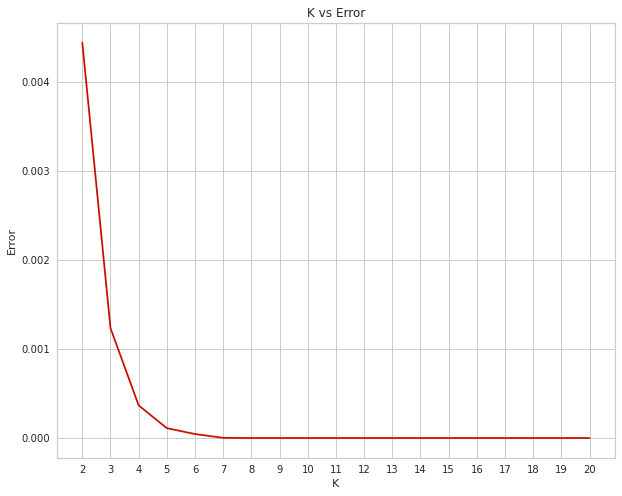

In [93]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [113]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [114]:
from yellowbrick.cluster import KElbowVisualizer         

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  self.estimato

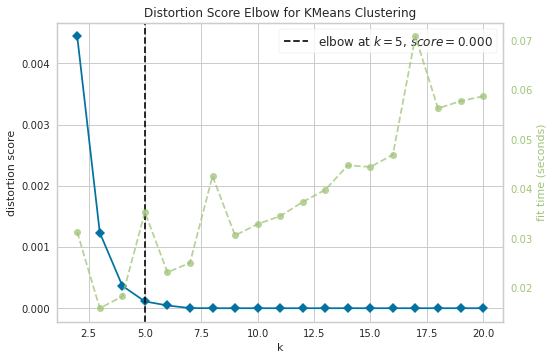

In [126]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

We see that the optimum K value is 5 so we will have a resulting of 4 clusters

In [127]:
kclusters = 5

toronto_grouped_clustering = ita.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [129]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = ita.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [130]:
to_merged.head()

Neighbourhood  Caribbean Restaurant  \
0                                        Agincourt                   0.0   
1                           Alderwood, Long Branch                   0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                   0.0   
3                                  Bayview Village                   0.0   
4                Bedford Park, Lawrence Manor East                   0.0   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               0

In [131]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighbourhood"), on="Neighbourhood")

print(to_merged.shape)
to_merged.head()

(2122, 9)


Neighbourhood  Caribbean Restaurant  Cluster Labels  \
0               Agincourt                   0.0               0   
0               Agincourt                   0.0               0   
0               Agincourt                   0.0               0   
0               Agincourt                   0.0               0   
1  Alderwood, Long Branch                   0.0               0   

   Neighbourhood Latitude  Neighbourhood Longitude  \
0               43.794200               -79.262029   
0               43.794200               -79.262029   
0               43.794200               -79.262029   
0               43.794200               -79.262029   
1               43.602414               -79.543484   

                              Venue  Venue Latitude  Venue Longitude  \
0       Panagio's Breakfast & Lunch       43.792370       -79.260203   
0                     El Pulgarcito       43.792648       -79.259208   
0                          Twilight       43.791999       -79.258584   
0                   Commander Arena       43.794867       -79.267989   
1  Il Paesano Pizzeria & Restaurant       43.601280       -79.545028   

              Venue Category  
0             Breakfast Spot  
0  Latin American Restaurant  
0                     Lounge  
0               Skating Rink  
1                Pizza Place

In [74]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(2122, 9)


Neighbourhood  Caribbean Restaurant  Cluster Labels  \
0                     Agincourt              0.000000               0   
63    Regent Park, Harbourfront              0.000000               0   
63    Regent Park, Harbourfront              0.000000               0   
63    Regent Park, Harbourfront              0.000000               0   
63    Regent Park, Harbourfront              0.000000               0   
..                          ...                   ...             ...   
15         Church and Wellesley              0.012821               4   
15         Church and Wellesley              0.012821               4   
15         Church and Wellesley              0.012821               4   
73  St. James Town, Cabbagetown              0.021739               4   
15         Church and Wellesley              0.012821               4   

    Neighbourhood Latitude  Neighbourhood Longitude  \
0                43.794200               -79.262029   
63               43.654260               -79.360636   
63               43.654260               -79.360636   
63               43.654260               -79.360636   
63               43.654260               -79.360636   
..                     ...                      ...   
15               43.665860               -79.383160   
15               43.665860               -79.383160   
15               43.665860               -79.383160   
73               43.667967               -79.367675   
15               43.665860               -79.383160   

                          Venue  Venue Latitude  Venue Longitude  \
0   Panagio's Breakfast & Lunch       43.792370       -79.260203   
63              Savoury Grounds       43.656821       -79.358970   
63              TD Canada Trust       43.652780       -79.356336   
63                       Vistek       43.657046       -79.359667   
63                        Izumi       43.649970       -79.360153   
..                          ...             ...              ...   
15           Sansotei Ramen 三草亭       43.666735       -79.385353   
15                 Como En Casa       43.665160       -79.384796   
15        Ho's Team Barber Shop       43.665630       -79.381359   
73    The Flying Beaver Pubaret       43.664829       -79.368292   
15       Hero Certified Burgers       43.665624       -79.380904   

        Venue Category  
0       Breakfast Spot  
63         Coffee Shop  
63                Bank  
63   Electronics Store  
63    Asian Restaurant  
..                 ...  
15    Ramen Restaurant  
15  Mexican Restaurant  
15  Salon / Barbershop  
73                 Pub  
15        Burger Joint  

[2122 rows x 9 columns]

Lets check how many Caribbean Restaurants are there

In [132]:
to_merged['Venue Category'].value_counts()['Caribbean Restaurant']

8

We see that there are a total of 8 locations with Caribbean Restaurants in Toronto
We will create a new dataframe with the Neighbourhood and Caribbean Restaurants

In [133]:
 #create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighbourhood Latitude'], to_merged['Neighbourhood Longitude'], to_merged['Neighbourhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

How many Neighborhoods per Cluster?

In [134]:
ita["Cluster Labels"] = kmeans.labels_
ita.head(5)

Neighbourhood  Caribbean Restaurant  \
0                                        Agincourt                   0.0   
1                           Alderwood, Long Branch                   0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                   0.0   
3                                  Bayview Village                   0.0   
4                Bedford Park, Lawrence Manor East                   0.0   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               0

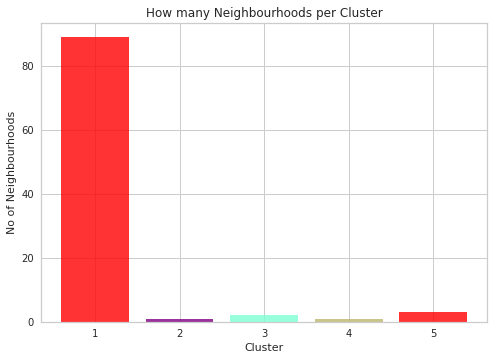

In [136]:
objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighbourhoods')
plt.xlabel('Cluster')
plt.title('How many Neighbourhoods per Cluster')

plt.show()

In [135]:
# How many neighborhoods in each cluster
ita['Cluster Labels'].value_counts()

0    89
4     3
2     2
3     1
1     1
Name: Cluster Labels, dtype: int64

Analysis of each Cluster

Cluster 1

In [138]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighbourhood']]
df_new.head()

Borough                           Neighbourhood
0  Scarborough                          Malvern, Rouge
1  Scarborough  Rouge Hill, Port Union, Highland Creek
2  Scarborough       Guildwood, Morningside, West Hill
3  Scarborough                                  Woburn
4  Scarborough                               Cedarbrae

In [140]:
# Red 

cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighbourhood')
df_cluster1

Borough                                      Neighbourhood  \
0     Scarborough                                     Malvern, Rouge   
1     Scarborough             Rouge Hill, Port Union, Highland Creek   
2     Scarborough             Rouge Hill, Port Union, Highland Creek   
3     Scarborough                  Guildwood, Morningside, West Hill   
4     Scarborough                  Guildwood, Morningside, West Hill   
...           ...                                                ...   
1892    Etobicoke  South Steeles, Silverstone, Humbergate, Jamest...   
1893    Etobicoke  South Steeles, Silverstone, Humbergate, Jamest...   
1894    Etobicoke                Northwest, West Humber - Clairville   
1895    Etobicoke                Northwest, West Humber - Clairville   
1896    Etobicoke                Northwest, West Humber - Clairville   

      Caribbean Restaurant  Cluster Labels  Neighbourhood Latitude  \
0                      0.0               0               43.806686   
1                      0.0               0               43.784535   
2                      0.0               0               43.784535   
3                      0.0               0               43.763573   
4                      0.0               0               43.763573   
...                    ...             ...                     ...   
1892                   0.0               0               43.739416   
1893                   0.0               0               43.739416   
1894                   0.0               0               43.706748   
1895                   0.0               0               43.706748   
1896                   0.0               0               43.706748   

      Neighbourhood Longitude                           Venue  Venue Latitude  \
0                  -79.194353                         Wendy’s       43.807448   
1                  -79.160497           Royal Canadian Legion       43.782533   
2                  -79.160497  Scarborough Historical Society       43.788755   
3                  -79.188711                  RBC Royal Bank       43.766790   
4                  -79.188711               G & G Electronics       43.765309   
...                       ...                             ...             ...   
1892               -79.588437                      McDonald's       43.741757   
1893               -79.588437                       Dollarama       43.742018   
1894               -79.594054              Economy Rent A Car       43.708471   
1895               -79.594054                   Saand Rexdale       43.705072   
1896               -79.594054            Vectra Heavy Haulers       43.704891   

      Venue Longitude        Venue Category  
0          -79.199056  Fast Food Restaurant  
1          -79.163085                   Bar  
2          -79.162438        History Museum  
3          -79.191151                  Bank  
4          -79.191537     Electronics Store  
...               ...                   ...  
1892       -79.584230  Fast Food Restaurant  
1893       -79.591076        Discount Store  
1894       -79.589943   Rental Car Location  
1895       -79.598725             Drugstore  
1896       -79.599410            Truck Stop  

[1897 rows x 10 columns]

Cluster 2

In [144]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighbourhood')

In [151]:
df_cluster2.sort_values(["Caribbean Restaurant"],ascending=False)

Borough                    Neighbourhood  Caribbean Restaurant  \
0  North York  Northwood Park, York University              0.166667   
1  North York  Northwood Park, York University              0.166667   
2  North York  Northwood Park, York University              0.166667   
3  North York  Northwood Park, York University              0.166667   
4  North York  Northwood Park, York University              0.166667   
5  North York  Northwood Park, York University              0.166667   

   Cluster Labels  Neighbourhood Latitude  Neighbourhood Longitude  \
0               1                43.76798               -79.487262   
1               1                43.76798               -79.487262   
2               1                43.76798               -79.487262   
3               1                43.76798               -79.487262   
4               1                43.76798               -79.487262   
5               1                43.76798               -79.487262   

                            Venue  Venue Latitude  Venue Longitude  \
0                MUSE Massage Spa       43.765686       -79.489318   
1                  Carribean Heat       43.764155       -79.490227   
2                     Tim Hortons       43.764289       -79.488790   
3                    Fox & Fiddle       43.763795       -79.488497   
4  Bad Boy Furniture - North York       43.764314       -79.486588   
5               Lastman's Bad Boy       43.763878       -79.486435   

           Venue Category  
0          Massage Studio  
1    Caribbean Restaurant  
2             Coffee Shop  
3                     Bar  
4  Furniture / Home Store  
5  Furniture / Home Store

In [152]:
df_cluster2['Venue Category'].value_counts(ascending=False)['Caribbean Restaurant']

1

Cluster 3

In [154]:
# Blue
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighbourhood')
df_cluster3

Borough                              Neighbourhood  \
0          North York                                  Don Mills   
1          North York                                  Don Mills   
2          North York                                  Don Mills   
3          North York                                  Don Mills   
4          North York                                  Don Mills   
..                ...                                        ...   
110  Downtown Toronto  Kensington Market, Chinatown, Grange Park   
111  Downtown Toronto  Kensington Market, Chinatown, Grange Park   
112  Downtown Toronto  Kensington Market, Chinatown, Grange Park   
113  Downtown Toronto  Kensington Market, Chinatown, Grange Park   
114  Downtown Toronto  Kensington Market, Chinatown, Grange Park   

     Caribbean Restaurant  Cluster Labels  Neighbourhood Latitude  \
0                0.040000               2               43.745906   
1                0.040000               2               43.745906   
2                0.040000               2               43.745906   
3                0.040000               2               43.745906   
4                0.040000               2               43.725900   
..                    ...             ...                     ...   
110              0.030769               2               43.653206   
111              0.030769               2               43.653206   
112              0.030769               2               43.653206   
113              0.030769               2               43.653206   
114              0.030769               2               43.653206   

     Neighbourhood Longitude               Venue  Venue Latitude  \
0                 -79.352188        Island Foods       43.745866   
1                 -79.352188       Baretto Caffé       43.744456   
2                 -79.352188          LA Fitness       43.747665   
3                 -79.352188         Gonoe Sushi       43.745737   
4                 -79.340923  Sorento Restaurant       43.726575   
..                       ...                 ...             ...   
110               -79.400049  Shoppers Drug Mart       43.653702   
111               -79.400049  Sweet Hart Kitchen       43.652929   
112               -79.400049            Pho Tien       43.652832   
113               -79.400049     The Supermarket       43.656680   
114               -79.400049     House of Jaffle       43.652053   

     Venue Longitude         Venue Category  
0         -79.346035   Caribbean Restaurant  
1         -79.346460                   Café  
2         -79.347077                    Gym  
3         -79.345991    Japanese Restaurant  
4         -79.341989     Italian Restaurant  
..               ...                    ...  
110       -79.406093               Pharmacy  
111       -79.404100           Dessert Shop  
112       -79.406242  Vietnamese Restaurant  
113       -79.402954                    Bar  
114       -79.404867            Snack Place  

[115 rows x 10 columns]

Cluster 4

In [155]:
# Turquoise
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighbourhood')
df_cluster4

Borough Neighbourhood  Caribbean Restaurant  Cluster Labels  \
0  Scarborough     Cedarbrae                 0.125               3   
1  Scarborough     Cedarbrae                 0.125               3   
2  Scarborough     Cedarbrae                 0.125               3   
3  Scarborough     Cedarbrae                 0.125               3   
4  Scarborough     Cedarbrae                 0.125               3   
5  Scarborough     Cedarbrae                 0.125               3   
6  Scarborough     Cedarbrae                 0.125               3   
7  Scarborough     Cedarbrae                 0.125               3   

   Neighbourhood Latitude  Neighbourhood Longitude  \
0               43.773136               -79.239476   
1               43.773136               -79.239476   
2               43.773136               -79.239476   
3               43.773136               -79.239476   
4               43.773136               -79.239476   
5               43.773136               -79.239476   
6               43.773136               -79.239476   
7               43.773136               -79.239476   

                          Venue  Venue Latitude  Venue Longitude  \
0           Federick Restaurant       43.774697       -79.241142   
1      Drupati's Roti & Doubles       43.775222       -79.241678   
2                   Thai One On       43.774468       -79.241268   
3  Centennial Recreation Centre       43.774593       -79.236500   
4               TD Canada Trust       43.774830       -79.241251   
5                    B&A Bakery       43.774391       -79.243877   
6                  Petro-Canada       43.774106       -79.243097   
7     Popeyes Louisiana Kitchen       43.775930       -79.235328   

         Venue Category  
0      Hakka Restaurant  
1  Caribbean Restaurant  
2       Thai Restaurant  
3    Athletics & Sports  
4                  Bank  
5                Bakery  
6           Gas Station  
7   Fried Chicken Joint

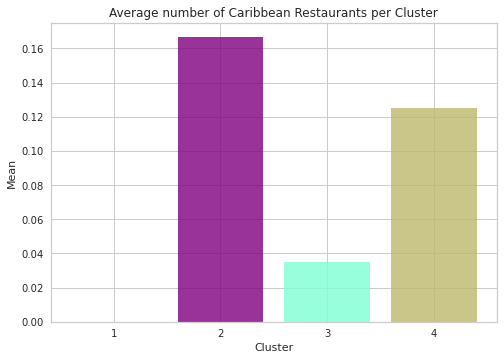

In [156]:
clusters_mean = [df_cluster1['Caribbean Restaurant'].mean(),df_cluster2['Caribbean Restaurant'].mean(),df_cluster3['Caribbean Restaurant'].mean(),
                 df_cluster4['Caribbean Restaurant'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Caribbean Restaurants per Cluster')

plt.show()

Observations

Most of the Caribbean Restaurants are in cluster 2 represented by the purple clusters. The Neighborhoods located in the North York area that have the highest average of Caribbean Restaurants. We see that in the Scarborough area (cluster 4) has the second highest average of Caribbean Restaurants. Looking at the nearby venues, the optimum place to put a new Caribbean Restaurant is in the Cedarbrae area since there are no Caribbean restaurants in this area. Nonetheless, from this research, opening a Caribbean Restaurant in Toronto is a huge opportunity since there is little to no competition. There are only 8 Caribbean Restaurants that serve a very large geographic are, so competition will be limited.